<a href="https://colab.research.google.com/github/nedokormysh/GB_NLP_intro/blob/lesson10/NLP_intro_hw_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 10
Разобраться с моделькой перевода как она устроена, запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания. Оценить качество насколько корректно переводит (для теста отобрать примеры с увеличением длины текста) (так как оценка визуальная достаточно 20-ти примеров в тестовой выборке).

# Без механизма внимания.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
!wget http://www.manythings.org/anki/rus-eng.zip

!rm -rf rus-eng
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng

--2023-03-26 11:27:29--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15374406 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.66M  30.4MB/s    in 0.5s    

2023-03-26 11:27:29 (30.4 MB/s) - ‘rus-eng.zip’ saved [15374406/15374406]

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [3]:
!ls /content/rus-eng/ -lah

total 74M
drwxr-xr-x 2 root root 4.0K Mar 26 11:27 .
drwxr-xr-x 1 root root 4.0K Mar 26 11:27 ..
-rw-r--r-- 1 root root 1.5K Feb 20 22:16 _about.txt
-rw-r--r-- 1 root root  74M Feb 20 22:16 rus.txt


In [4]:
# Download the file
path_to_file = "rus-eng/rus.txt"

In [5]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [7]:
# 2. Отчищаем предложения
# 3. Возвращаем пары слов: [ENG, RUS]

# Создаем датасет распределяя текст по парам
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [8]:
lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
r = lines[:1]

In [9]:
# r.split()[:2]

In [10]:
en, ru = create_dataset(path_to_file, None)
print(en[30])
print(ru[30])

<start> hide . <end>
<start> спрячьтесь . <end>


Дополнительные вспомогательные процедуры для токенизации текста и создания тензоров из датасета.

In [11]:
# Токенизация

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer


# Создание датасета

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
len(en), len(ru)

(464010, 464010)

In [13]:
# Эксперементируем с размером датасета
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Вычисляем максимальную длинну целевого тензора
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Разбиваем датасет на тренировочную и валидационные выборки (80/20)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Длина тензора
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1156 ----> попросите
18 ----> тома
1328 ----> спеть
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
128 ----> ask
5 ----> tom
11 ----> to
199 ----> sing
3 ----> .
2 ----> <end>


In [17]:
# Создание tensorflow датасета

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [19]:
# Энкодер

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    

  def call(self, x, hidden):
    # x - приходит текст, кидаем его в эмбединг
    x = self.embedding(x)
    # уже этот эмбединг кидаем в гру. x - размерность выходного пространства
    output, state = self.gru(x, initial_state = hidden)
    # возвращаем аутпут и стейт, здесь аутпут не нужен, т.к. не используем т.к. нет внимания
    return state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
# Декодер

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden):
    # enc_output shape == (batch_size, max_length, hidden_size)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

In [23]:
# Оптимизатор и лосс-функция

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
            # маска будет занулять нулевые токены паддинга , 
            # через которые мы не хотим прокидывать градиент, 
            # поэтому мы их сразу в лоссе зануляем чтобы они на лосс никак не реагировали, 
            # чтобы не вносили добавочные коэффициенты в наш лосс

  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [24]:
# x = tf.constant([2, 4])
# y = tf.constant([2, 5])
# tf.math.equal(x, y)

In [25]:
# Создание чекпоинтов

!rm -rf ./training_checkpoints

checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [26]:
# Обучение

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [27]:
%time
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs
Epoch 1 Batch 0 Loss 4.5402
Epoch 1 Batch 100 Loss 1.9809
Epoch 1 Batch 200 Loss 1.7436
Epoch 1 Batch 300 Loss 1.5787
Epoch 1 Batch 400 Loss 1.5040
Epoch 1 Batch 500 Loss 1.3868
Epoch 1 Batch 600 Loss 1.3761
Epoch 1 Batch 700 Loss 1.3181
Epoch 1 Batch 800 Loss 1.1347
Epoch 1 Batch 900 Loss 1.1004
Epoch 1 Batch 1000 Loss 1.0098
Epoch 1 Batch 1100 Loss 1.0773
Epoch 1 Batch 1200 Loss 1.0238
Epoch 1 Loss 1.4058
Time taken for 1 epoch 77.57141828536987 sec

Epoch 2 Batch 0 Loss 0.8051
Epoch 2 Batch 100 Loss 0.7880
Epoch 2 Batch 200 Loss 0.6708
Epoch 2 Batch 300 Loss 0.7967
Epoch 2 Batch 400 Loss 0.6993
Epoch 2 Batch 500 Loss 0.6200
Epoch 2 Batch 600 Loss 0.6548
Epoch 2 Batch 700 Loss 0.5455
Epoch 2 Batch 800 Loss 0.6522
Epoch 2 Batch 900 Loss 0.6643
Epoch 2 Batch 1000 Loss 0.5696
Epoch 2 Batch 1100 Loss 0.5676
Epoch 2 Batch 1200 Loss 0.5308
Epoch 2 Loss 0.6698
Time taken for 1 epoch 56.02265906333923 sec

Epoch 3 Batch 0 Lo

In [28]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [29]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

In [30]:
# Восстанавливаем последний чекпоинт
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
# Тестируем

test_texts = ['Привет.',  'Пора уходить.', 'Замечательная новость',
              'Я делаю домашнюю работу.', 'Футбольный клуб.',
              'Перевод без внимания', 'Пишу более длинное предложение для модели',
              ]

for text in test_texts:
    translate(text)

Input: <start> привет . <end>
Predicted translation: hi . <end> 
Input: <start> пора уходить . <end>
Predicted translation: it's time to leave . <end> 
Input: <start> замечательная новость <end>
Predicted translation: what news is this ? <end> 
Input: <start> я делаю домашнюю работу . <end>
Predicted translation: i do some fish . <end> 
Input: <start> футбольный клуб . <end>
Predicted translation: the pen is gone . <end> 
Input: <start> перевод без внимания <end>
Predicted translation: swim or miss all pass ? <end> 
Input: <start> пишу более длинное предложение для модели <end>
Predicted translation: ask more or wide up . <end> 


Перевод некачественный. Кроме того, если в словаре нет слова - появляется ошибка.

# С механизмом внимания

In [35]:
# Энкодер

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [36]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [37]:
# Attention

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [38]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [39]:
# Декодер

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [40]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7350)


In [41]:
# Оптимайзер и лосс функция

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [42]:
# Чекпоинты

!rm -rf ./training_attention_checkpoints

checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [43]:
# Обучение

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [44]:
%time
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
Epoch 1 Batch 0 Loss 4.4763
Epoch 1 Batch 100 Loss 2.1706
Epoch 1 Batch 200 Loss 1.8183
Epoch 1 Batch 300 Loss 1.6903
Epoch 1 Batch 400 Loss 1.5828
Epoch 1 Batch 500 Loss 1.4450
Epoch 1 Batch 600 Loss 1.4599
Epoch 1 Batch 700 Loss 1.3871
Epoch 1 Batch 800 Loss 1.1383
Epoch 1 Batch 900 Loss 1.0263
Epoch 1 Batch 1000 Loss 1.0414
Epoch 1 Batch 1100 Loss 0.9496
Epoch 1 Batch 1200 Loss 0.9341
Epoch 1 Loss 1.4500
Time taken for 1 epoch 121.16988706588745 sec

Epoch 2 Batch 0 Loss 0.7368
Epoch 2 Batch 100 Loss 0.7318
Epoch 2 Batch 200 Loss 0.7142
Epoch 2 Batch 300 Loss 0.6372
Epoch 2 Batch 400 Loss 0.5958
Epoch 2 Batch 500 Loss 0.5608
Epoch 2 Batch 600 Loss 0.6528
Epoch 2 Batch 700 Loss 0.5883
Epoch 2 Batch 800 Loss 0.6034
Epoch 2 Batch 900 Loss 0.4484
Epoch 2 Batch 1000 Loss 0.4604
Epoch 2 Batch 1100 Loss 0.5238
Epoch 2 Batch 1200 Loss 0.4583
Epoch 2 Loss 0.6047
Time taken for 1 epoch 99.69309163093567 sec

Epoch 3 Batch 0 Loss 0

In [45]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [46]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [47]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> привет . <end>
Predicted translation: hi . <end> 


<ipython-input-46-ef64c003f9d5>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-46-ef64c003f9d5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


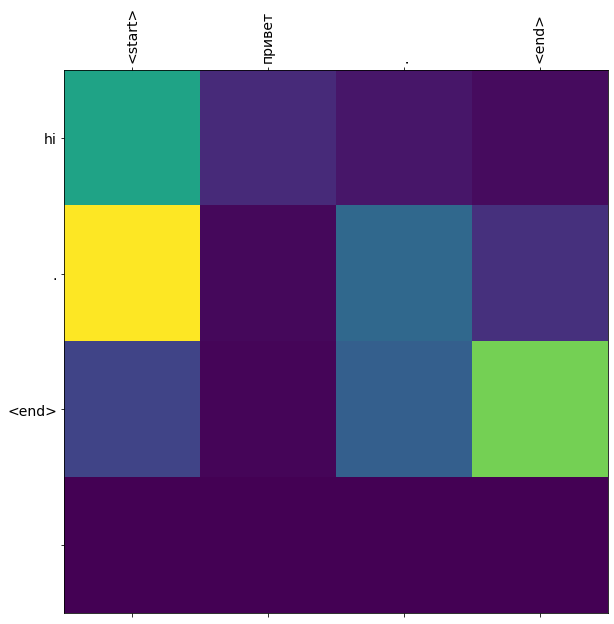

Input: <start> пора уходить . <end>
Predicted translation: it's time to leave . <end> 


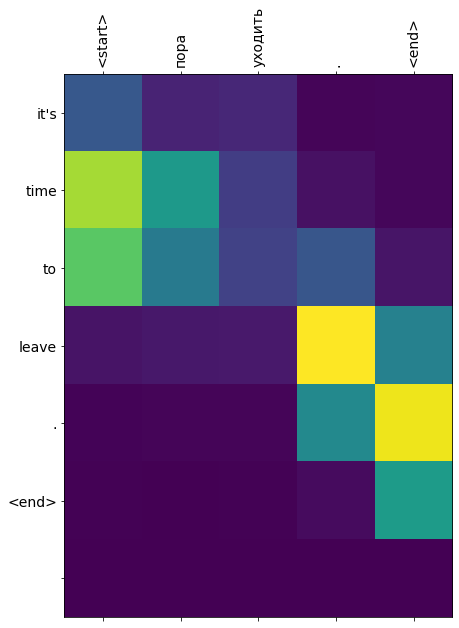

Input: <start> замечательная новость <end>
Predicted translation: a great news . <end> 


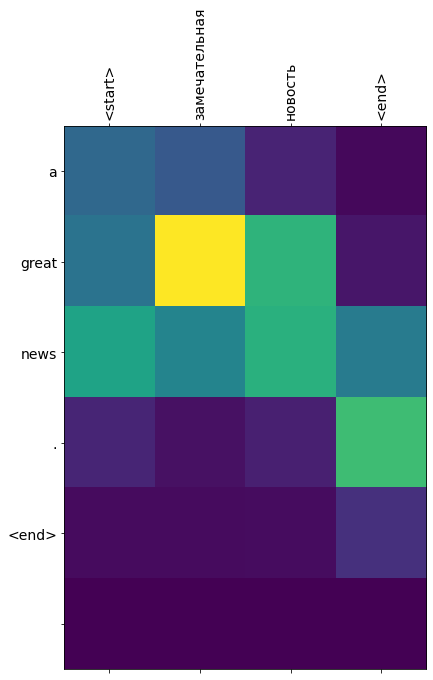

Input: <start> я делаю домашнюю работу . <end>
Predicted translation: i do dance lessons . <end> 


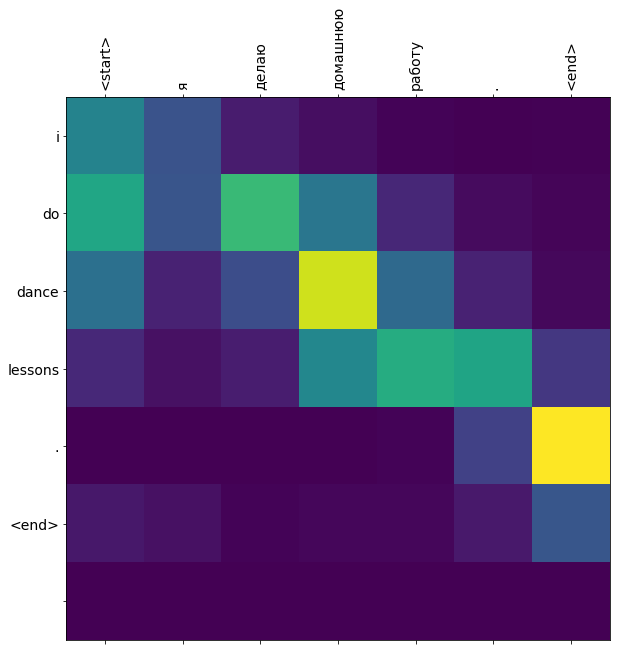

Input: <start> футбольный клуб . <end>
Predicted translation: deal is a little . <end> 


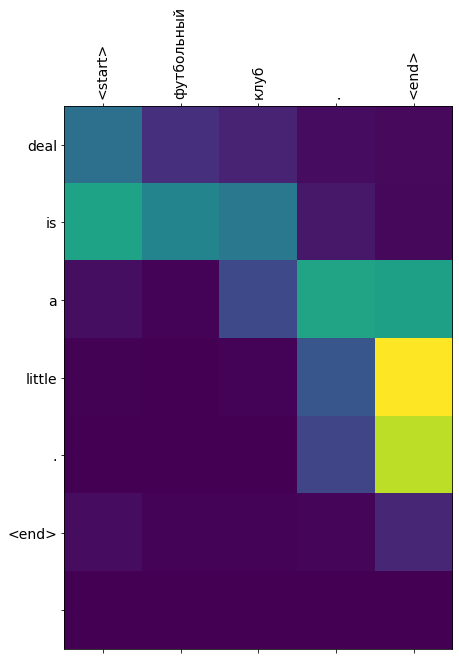

Input: <start> перевод без внимания <end>
Predicted translation: go talk . <end> 


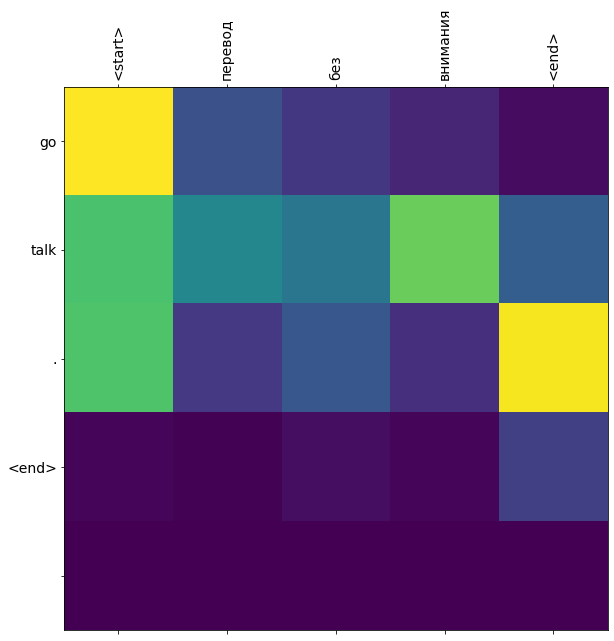

Input: <start> пишу более длинное предложение для модели <end>
Predicted translation: publish more letters easily . <end> 


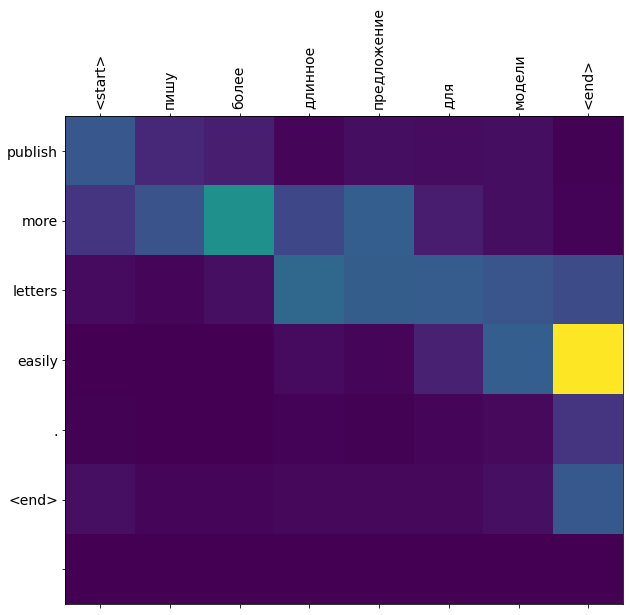

In [51]:
# Тестируем

test_text = ['Привет.',  'Пора уходить.', 'Замечательная новость',
              'Я делаю домашнюю работу.', 'Футбольный клуб.',
              'Перевод без внимания', 'Пишу более длинное предложение для модели',
              ]

for text in test_text:
    translate(text)